<a href="https://colab.research.google.com/github/niconielsen32/NeuralNetworks/blob/main/autoencoder_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(123456)

In [ ]:
data = torchvision.datasets.MNIST(root='~/data', download=True)
data = data.data
data = data.float() / 255.
data = data.view(-1, 1, 28, 28)
print(data.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([60000, 1, 28, 28])


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        x = self.decoder(x)
        return x.view(-1,1,28,28)

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
model = AutoEncoder().cuda()
opt = torch.optim.Adam(model.parameters())

In [ ]:
for epoch in range(25):
    print(f'Epoch {epoch+1}/25')
    for i in range(0, data.shape[0], 32):
        x = data[i:i+32].cuda()
        x_rec = model(x)
        loss = F.binary_cross_entropy(x_rec, x)

        opt.zero_grad()
        loss.backward()
        opt.step()

    data = data[rng.permutation(len(data))]
    print(f'\tloss: {loss.item():.4f}')

Epoch 1/25
	loss: 0.1552
Epoch 2/25
	loss: 0.1270
Epoch 3/25
	loss: 0.1206
Epoch 4/25
	loss: 0.1324
Epoch 5/25
	loss: 0.1237
Epoch 6/25
	loss: 0.1256
Epoch 7/25
	loss: 0.1357
Epoch 8/25
	loss: 0.1197
Epoch 9/25
	loss: 0.1368
Epoch 10/25
	loss: 0.1163
Epoch 11/25
	loss: 0.1418
Epoch 12/25
	loss: 0.1164
Epoch 13/25
	loss: 0.1288
Epoch 14/25
	loss: 0.1217
Epoch 15/25
	loss: 0.1252
Epoch 16/25
	loss: 0.1132
Epoch 17/25
	loss: 0.1180
Epoch 18/25
	loss: 0.1194
Epoch 19/25
	loss: 0.1155
Epoch 20/25
	loss: 0.1237
Epoch 21/25
	loss: 0.1141
Epoch 22/25
	loss: 0.1259
Epoch 23/25
	loss: 0.1217
Epoch 24/25
	loss: 0.1208
Epoch 25/25
	loss: 0.1151


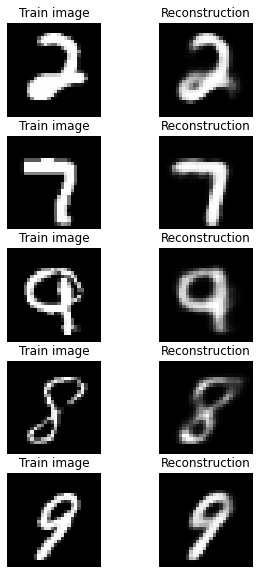

In [ ]:
plt.figure(figsize=(5,10))

for i in range(5):
    plt.subplot(5, 2, i*2+1, title=f'Train image')
    plt.imshow(np.squeeze(x[i].cpu()), cmap='gray')
    plt.axis('off')
    
    plt.subplot(5, 2, i*2+2, title='Reconstruction')
    with torch.no_grad(): plt.imshow(np.squeeze(x_rec[i].cpu()), cmap='gray')
    plt.axis('off')
    

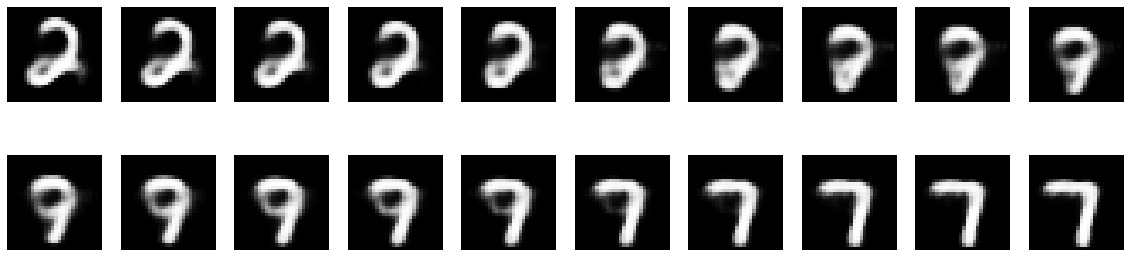

In [ ]:
# Sample two random images and encode
f = model.encode(x[0:2])
f1,f2 = f[0].unsqueeze(0),f[1].unsqueeze(0)

# Show reconstructions of interpolated codes
plt.figure(figsize=(20,5))
reconstructions = []
for i in range(20):
    v = i/19.
    f_interp = f1*(1-v) + f2*v
    with torch.no_grad():
        x_rec_interp = np.squeeze(model.decode(f_interp).cpu())
        reconstructions.append(x_rec_interp)
    
    plt.subplot(2,10,i+1)
    plt.imshow(x_rec_interp, cmap='gray')
    plt.axis('off')


Latent interpolation


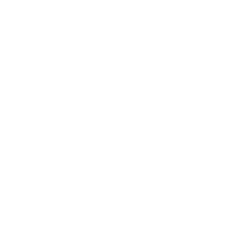

In [ ]:
from IPython.display import HTML
from matplotlib import animation

fig = plt.figure()
plt.axis('off')
artists = [[plt.imshow(img, animated=False, cmap='gray')] for img in reconstructions]
ani = animation.ArtistAnimation(fig, artists, interval=200, blit=False, repeat_delay=1000)

print('Latent interpolation')
HTML(ani.to_html5_video())

Pixel interpolation


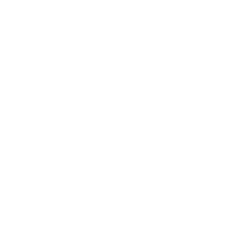

In [ ]:
img1,img2 = x[0],x[2]
images = []
for i in range(20):
    v = i/19.
    img_interp = img1*(1-v) + img2*v
    images.append(np.squeeze(img_interp.cpu()))

fig = plt.figure()
plt.axis('off')
artists = [[plt.imshow(img, animated=False, cmap='gray')] for img in images]
ani = animation.ArtistAnimation(fig, artists, interval=200, blit=False, repeat_delay=1000)

print('Pixel interpolation')
HTML(ani.to_html5_video())